Training: 1354 Validation: 812 Test: 542


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:25:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Candidate Laplacian dimension d=2: Validation Macro Precision = 0.7313


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Candidate Laplacian dimension d=3: Validation Macro Precision = 0.7322


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Candidate Laplacian dimension d=4: Validation Macro Precision = 0.7368


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:25:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Candidate Laplacian dimension d=5: Validation Macro Precision = 0.7414
Best Laplacian embedding dimension chosen: 5


/Users/victormpreciado/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:25:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Precision (macro-average): 0.7927730425718353


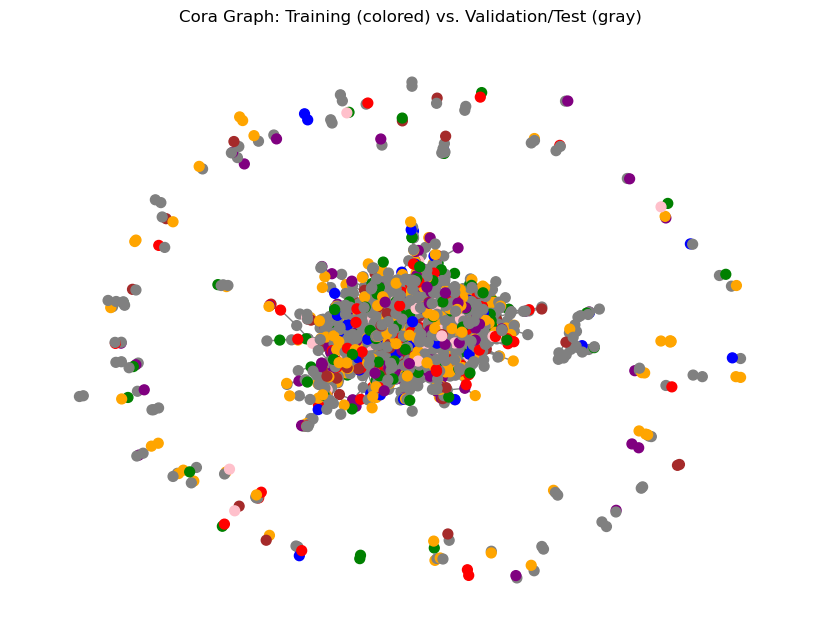

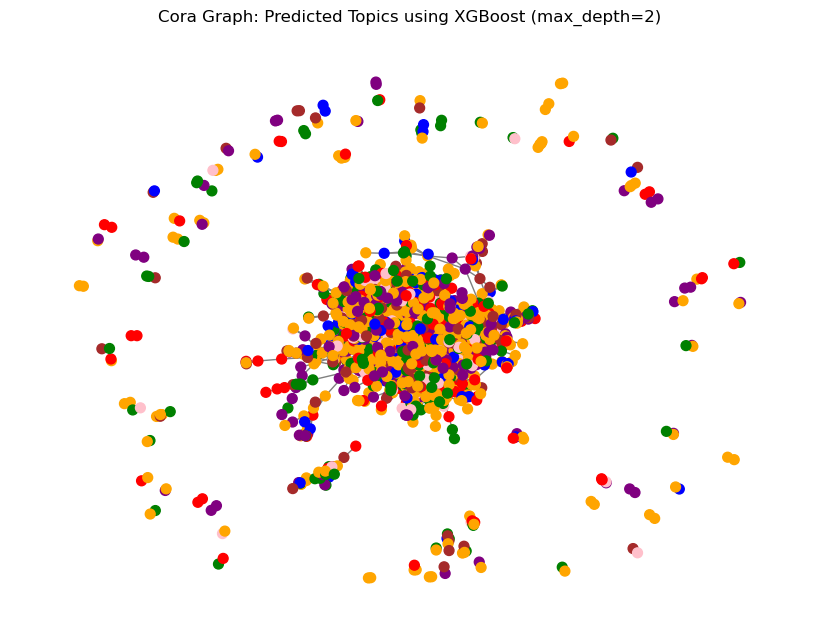

In [1]:
!pip install xgboost
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from xgboost import XGBClassifier
from sklearn.metrics import precision_score

# --- Step 1: Load the Cora Dataset ---
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
true_labels = data.y.numpy()  # Ground-truth topics (0 to 6)

# --- Step 2: Build a NetworkX Graph from the Cora Data ---
edge_index = data.edge_index.numpy()  # shape: [2, num_edges]
G = nx.Graph()
G.add_edges_from(edge_index.T)

# --- Step 3: Compute the Normalized Laplacian and its Eigen-Decomposition ---
# Compute the normalized Laplacian matrix and its eigen-decomposition.
L = nx.normalized_laplacian_matrix(G).todense()
eigvals, eigvecs = np.linalg.eigh(L)

# --- Step 4: Split the Data (50% train, 30% validation, 20% test) ---
num_nodes = data.num_nodes
indices = np.arange(num_nodes)
np.random.seed(42)
np.random.shuffle(indices)

train_count = int(0.5 * num_nodes)
val_count   = int(0.3 * num_nodes)
test_count  = num_nodes - train_count - val_count

train_idx = indices[:train_count]
val_idx   = indices[train_count:train_count+val_count]
test_idx  = indices[train_count+val_count:]

print("Training:", len(train_idx), "Validation:", len(val_idx), "Test:", len(test_idx))

# --- Step 5: Cross-Validate to Choose the Laplacian Embedding Dimension ---
candidate_dims = [2, 3, 4, 5]
best_d = None
best_val_score = -np.inf

# We'll compute enriched features for each candidate d and evaluate on the validation set.
for d in candidate_dims:
    # Compute Laplacian embedding using the first d non-trivial eigenvectors
    # (skip the first trivial eigenvector corresponding to eigenvalue 0)
    lap_embedding = eigvecs[:, 1:1+d]  # shape: (n_nodes, d)

    # Combine with the original bag-of-words features
    features_original = data.x.numpy()  # shape: (n_nodes, num_features)
    features_enriched = np.concatenate([features_original, lap_embedding], axis=1)

    # Train XGBoost classifier with fixed max_depth=2 on the training set
    clf = XGBClassifier(max_depth=2, random_state=42,
                        use_label_encoder=False, eval_metric='mlogloss')
    clf.fit(features_enriched[train_idx], true_labels[train_idx])

    # Predict on the validation set and compute macro-average precision
    preds_val = clf.predict(features_enriched[val_idx])
    val_score = precision_score(true_labels[val_idx], preds_val,
                                average='macro', zero_division=0)
    print(f"Candidate Laplacian dimension d={d}: Validation Macro Precision = {val_score:.4f}")

    if val_score > best_val_score:
        best_val_score = val_score
        best_d = d
        best_features_enriched = features_enriched.copy()  # Save the best enriched features

print("Best Laplacian embedding dimension chosen:", best_d)

# --- Step 6: Retrain XGBoost on the Combined Training and Validation Data ---
train_val_idx = np.concatenate([train_idx, val_idx])
clf_final = XGBClassifier(max_depth=2, random_state=42,
                          use_label_encoder=False, eval_metric='mlogloss')
clf_final.fit(best_features_enriched[train_val_idx], true_labels[train_val_idx])
predicted_labels = clf_final.predict(best_features_enriched)

# --- Step 7: Evaluate on Test Data ---
test_precision = precision_score(true_labels[test_idx],
                                 predicted_labels[test_idx],
                                 average='macro', zero_division=0)
print("Test Precision (macro-average):", test_precision)

# --- Step 8: Visualization ---
# Define a color map for the 7 topics
color_map = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

# Plot 1: Cora graph with training nodes colored (true labels) and validation/test nodes in gray
node_colors_plot1 = []
for i in range(num_nodes):
    if i in train_idx:
        node_colors_plot1.append(color_map[true_labels[i] % len(color_map)])
    else:
        node_colors_plot1.append('gray')

plt.figure(figsize=(8, 6))
nx.draw(G, node_color=node_colors_plot1, node_size=50, edge_color='gray', with_labels=False)
plt.title("Cora Graph: Training (colored) vs. Validation/Test (gray)")
plt.show()

# Plot 2: Cora graph with all nodes colored by predicted topics
node_colors_plot2 = [color_map[predicted_labels[i] % len(color_map)] for i in range(num_nodes)]
plt.figure(figsize=(8, 6))
nx.draw(G, node_color=node_colors_plot2, node_size=50, edge_color='gray', with_labels=False)
plt.title("Cora Graph: Predicted Topics using XGBoost (max_depth=2)")
plt.show()